# The Battle of Neighborhood - Source Code

## Install and Import packages

In [1]:
# !pip install folium
# !pip install geopandas
# !pip install ipython-sql
# !pip install ibm_db 
# !pip install ibm_db_sa
# !pip install pydeck
# !pip install descartes

In [2]:
import pandas as pd
import geopandas as gpd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import pydeck as pdk

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

import folium
print('Libraries imported.')

Libraries imported.


## Data 1: Import dataset with GeoPandas

In [3]:
url = "https://raw.githubusercontent.com/vuski/admdongkor/master/ver20200101/HangJeongDong_ver20200101.geojson"

In [4]:
geo_df = gpd.read_file(url)

### using centroid to get center point of multipolygon

In [5]:
geo_df['centroid'] = geo_df['geometry'].centroid

geo_df['long'] = geo_df.centroid.x
geo_df['lat'] = geo_df.centroid.y

In [6]:
def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)]

geo_df['coordinates'] = geo_df['geometry'].apply(multipolygon_to_coordinates)

In [7]:
print(geo_df.shape)
geo_df.head()

(3482, 9)


,OBJECTID,adm_nm,adm_cd,adm_cd2,geometry,centroid,long,lat,coordinates
0,1,서울특별시 종로구 사직동,1101053,1111053000,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ...",POINT (126.97014 37.57411),126.970144,37.574108,"[[126.97688884274817, 37.575650779448786], [12..."
1,2,서울특별시 종로구 삼청동,1101054,1111054000,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ...",POINT (126.98111 37.58801),126.981114,37.588013,"[[126.98268938649305, 37.5950655194224], [126...."
2,3,서울특별시 종로구 부암동,1101055,1111055000,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ...",POINT (126.96256 37.59670),126.962557,37.596699,"[[126.97585113775686, 37.59656422224408], [126..."
3,4,서울특별시 종로구 평창동,1101056,1111056000,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ...",POINT (126.96927 37.61397),126.969274,37.613965,"[[126.97507466788086, 37.63138628651299], [126..."
4,5,서울특별시 종로구 무악동,1101057,1111057000,"MULTIPOLYGON (((126.96067 37.58080, 126.96281 ...",POINT (126.95899 37.57774),126.958989,37.577741,"[[126.96067353273895, 37.580797842029725], [12..."


### Separate address value into 3 section - City, District, Neighborhood

In [8]:
geo_df['city'] = geo_df['adm_nm'].str.split(expand=True)[0]
geo_df['District'] = geo_df['adm_nm'].str.split(expand=True)[1]
geo_df['Neighborhood'] = geo_df['adm_nm'].str.split(expand=True)[2]

print(geo_df.shape)
geo_df.head()

(3482, 12)


,OBJECTID,adm_nm,adm_cd,adm_cd2,geometry,centroid,long,lat,coordinates,city,District,Neighborhood
0,1,서울특별시 종로구 사직동,1101053,1111053000,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ...",POINT (126.97014 37.57411),126.970144,37.574108,"[[126.97688884274817, 37.575650779448786], [12...",서울특별시,종로구,사직동
1,2,서울특별시 종로구 삼청동,1101054,1111054000,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ...",POINT (126.98111 37.58801),126.981114,37.588013,"[[126.98268938649305, 37.5950655194224], [126....",서울특별시,종로구,삼청동
2,3,서울특별시 종로구 부암동,1101055,1111055000,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ...",POINT (126.96256 37.59670),126.962557,37.596699,"[[126.97585113775686, 37.59656422224408], [126...",서울특별시,종로구,부암동
3,4,서울특별시 종로구 평창동,1101056,1111056000,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ...",POINT (126.96927 37.61397),126.969274,37.613965,"[[126.97507466788086, 37.63138628651299], [126...",서울특별시,종로구,평창동
4,5,서울특별시 종로구 무악동,1101057,1111057000,"MULTIPOLYGON (((126.96067 37.58080, 126.96281 ...",POINT (126.95899 37.57774),126.958989,37.577741,"[[126.96067353273895, 37.580797842029725], [12...",서울특별시,종로구,무악동


### Manage adm_cd2 value as South Korea government areacode, and define as new Data Frame

In [9]:
geo_seoul_df = geo_df[geo_df['city'].str.contains('서울')]
seoul_df = geo_seoul_df[['city', 'District', 'Neighborhood', 'adm_cd2', 'long', 'lat', 'geometry', 'coordinates']]
seoul_df['Areacode'] = seoul_df['adm_cd2'].str.slice(start=0, stop=8)

print(seoul_df.shape)
seoul_df.head()

(425, 9)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,city,District,Neighborhood,adm_cd2,long,lat,geometry,coordinates,Areacode
0,서울특별시,종로구,사직동,1111053000,126.970144,37.574108,"MULTIPOLYGON (((126.97689 37.57565, 126.97703 ...","[[126.97688884274817, 37.575650779448786], [12...",11110530
1,서울특별시,종로구,삼청동,1111054000,126.981114,37.588013,"MULTIPOLYGON (((126.98269 37.59507, 126.98337 ...","[[126.98268938649305, 37.5950655194224], [126....",11110540
2,서울특별시,종로구,부암동,1111055000,126.962557,37.596699,"MULTIPOLYGON (((126.97585 37.59656, 126.97359 ...","[[126.97585113775686, 37.59656422224408], [126...",11110550
3,서울특별시,종로구,평창동,1111056000,126.969274,37.613965,"MULTIPOLYGON (((126.97507 37.63139, 126.97649 ...","[[126.97507466788086, 37.63138628651299], [126...",11110560
4,서울특별시,종로구,무악동,1111057000,126.958989,37.577741,"MULTIPOLYGON (((126.96067 37.58080, 126.96281 ...","[[126.96067353273895, 37.580797842029725], [12...",11110570


### Visualize Seoul neighborhood data with folium map

In [10]:
seoul_lat = 37.541
seoul_long = 126.986

In [11]:
# create map of Toronto using latitude and longitude values
Seoul_Map = folium.Map(location=[seoul_lat, seoul_long], zoom_start=11, width='85%', height='70%')

# add markers to map
for lat, lng, District, Neighborhood in zip(seoul_df['lat'], seoul_df['long'], seoul_df['District'], seoul_df['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, District)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Seoul_Map)
    
[folium.Choropleth(geo_data=polygon, fill_color='#C3DEFF').add_to(Seoul_Map) for polygon in seoul_df['geometry']]

In [12]:
Seoul_Map

### change data type of Areacode to integer, it will utilized when merge two data frames as a key

In [13]:
seoul_df['Areacode'] = seoul_df['Areacode'].astype('int64')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Data 2: import data from IBM cloud DB2, SQL

SQL Magic

In [14]:
%load_ext sql

In [15]:
# Enter the connection string for your Db2 on Cloud database instance below
# %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name
%sql ibm_db_sa://xgk41464:52sl567zx5r4-77t@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB

'Connected: xgk41464@BLUDB'

In [16]:
seoul_living = %sql select * from seoul_living2
seoul_living_df = seoul_living.DataFrame()

 * ibm_db_sa://xgk41464:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


### Check Dataset shape

In [17]:
print(seoul_living_df.shape)
seoul_living_df.head()

(315456, 33)


,date,hour,Areacode,Total,male_0to9,male_10to14,male_15to19,male_20to24,male_25to29,male_30to34,...,female_30to34,female_35to39,female_40to44,female_45to49,female_50to54,female_55to59,female_60to64,female_65to69,female_over70,Column_32
0,20181001,0,11320511,25354.5456999999990,702.0565,421.10140000000001,606.42020000000002,698.04480000000001,788.94449999999995,883.49360000000001,...,1016.7237,970.14350000000002,1000.5696,1155.4472000000001,963.20500000000004,1181.4119000000001,1143.0341000000001,783.17830000000004,2137.4794999999999,
1,20181001,0,11140635,18969.1407000000000,533.1224,192.89609999999999,288.51409999999998,361.61619999999999,662.49149999999997,628.70090000000005,...,885.94290000000001,922.10000000000002,827.32420000000002,769.53989999999999,636.55240000000003,836.31669999999997,852.98540000000003,666.577,1938.2016000000001,
2,20181001,0,11620645,28319.0417999999990,638.5654,255.68109999999999,497.77749999999997,1635.5909999999999,2517.3822,2031.6425999999999,...,1388.9476999999999,1075.5289,713.50350000000003,681.60469999999998,830.00879999999995,1075.0893000000001,795.57600000000002,655.33000000000004,1612.615,
3,20181001,0,11215770,35403.5017000000010,1083.2252,528.89800000000002,956.26900000000001,868.56640000000004,1319.0915,1427.7864999999999,...,1436.9236000000001,1417.693,1303.9428,1464.2603999999999,1594.5488,1565.8140000000001,1462.2116000000001,1127.3451,2562.6682000000001,
4,20181001,0,11560670,7932.3008000000000,144.7819,108.4624,175.58920000000001,223.87260000000001,271.19729999999998,294.27330000000001,...,274.78910000000002,252.98750000000001,336.75439999999998,293.6096,382.2088,429.35980000000001,388.51990000000001,279.14490000000001,611.5027,


### Merge Two Data Frame into one

In [18]:
seoul_living_df2 = pd.merge(seoul_living_df, seoul_df[['Areacode', 'District', 'Neighborhood']], how='left', on='Areacode')

### Separate dataframe based on hour - working hour, after working hour, and the rest
 * change data type as numeric value

In [19]:
seoul_working = seoul_living_df2[seoul_living_df2['hour'].between(8, 19)]
seoul_afterwork = seoul_living_df2[seoul_living_df2['hour'].between(20, 23) | (seoul_living_df2['hour'] == 0) | (seoul_living_df2['hour'] == 1)]
seoul_dawn = seoul_living_df2[seoul_living_df2['hour'].between(2, 7)]

seoul_working[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']] = seoul_working[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']].astype('float').astype('int')

seoul_afterwork[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']] = seoul_afterwork[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']].astype('float').astype('int')

seoul_dawn[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']] = seoul_dawn[['Total', 'male_0to9', 'male_10to14', 'male_15to19', 'male_20to24', 'male_25to29', 'male_30to34', 'male_35to39', 
'male_40to44', 'male_45to49','male_50to54', 'male_55to59', 'male_60to64', 'male_65to69', 'male_over70', 
'female_0to9', 'female_10to14', 'felame_15to19', 'female_20to24', 'female_25to29', 'female_30to34', 'female_35to39', 
'female_40to44', 'female_45to49', 'female_50to54', 'female_55to59', 'female_60to64', 'female_65to69', 'female_over70']].astype('float').astype('int')

print(seoul_working.shape)
print(seoul_afterwork.shape)
print(seoul_dawn.shape)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


(157728, 35)
(78864, 35)
(78864, 35)


### Sort value by Total groupby District & Neighborhood

In [20]:
working_sort = seoul_working[['Areacode', 'Total', 'District', 'Neighborhood']].groupby(['District', 'Neighborhood', 'Areacode']).sum().sort_values(by='Total', ascending=False)
working_total = working_sort['Total'].sum()
working_sort['Per'] = (working_sort['Total'] / working_total) * 100
working_sort = working_sort.reset_index()

work_sort_100 = working_sort.head(100)

work_sort_100.head(1)

,District,Neighborhood,Areacode,Total,Per
0,강남구,역삼1동,11680640,53324868,1.297123


### Get the Top100 values from sorted Dataframe of business hour, and count the unique District

In [71]:
work_sort_100.head()

,District,Neighborhood,Areacode,Total,Per
0,강남구,역삼1동,11680640,53324868,1.297123
1,영등포구,여의동,11560540,49989377,1.215987
2,종로구,종로1·2·3·4가동,11110615,41123842,1.000334
3,마포구,서교동,11440660,36206535,0.880721
4,금천구,가산동,11545510,31985589,0.778047


In [22]:
work_sort_100['Per'].sum()

44.17720768748581

In [23]:
work_sort_100['District'].value_counts().head(8)

강남구    12
서초구     9
송파구     9
강서구     8
구로구     5
노원구     5
마포구     5
동작구     5
Name: District, dtype: int64

### Visualize population

In [48]:
work_plot = seoul_df.merge(working_sort[['Areacode', 'Total']], on='Areacode')

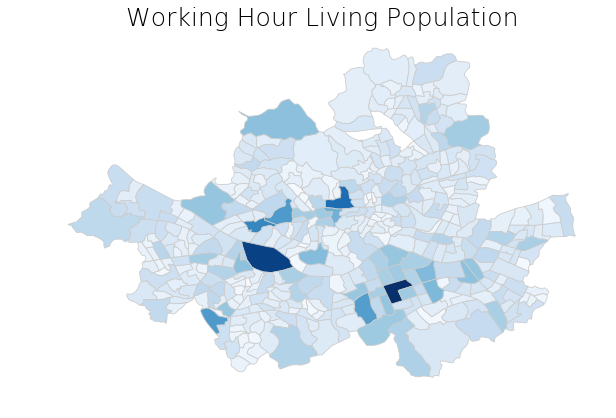

In [59]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.axis('off')
ax.set_title('Working Hour Living Population', fontdict={'fontsize': '25', 'fontweight' : '3'})
work_plot.plot(column='Total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

### Get the Top100 values from sorted Dataframe of after business hour, and count the unique District

In [25]:
seoul_afterwork.head()

,date,hour,Areacode,Total,male_0to9,male_10to14,male_15to19,male_20to24,male_25to29,male_30to34,...,female_40to44,female_45to49,female_50to54,female_55to59,female_60to64,female_65to69,female_over70,Column_32,District,Neighborhood
0,20181001,0,11320511,25354,702,421,606,698,788,883,...,1000,1155,963,1181,1143,783,2137,,도봉구,창1동
1,20181001,0,11140635,18969,533,192,288,361,662,628,...,827,769,636,836,852,666,1938,,중구,약수동
2,20181001,0,11620645,28319,638,255,497,1635,2517,2031,...,713,681,830,1075,795,655,1612,,관악구,서원동
3,20181001,0,11215770,35403,1083,528,956,868,1319,1427,...,1303,1464,1594,1565,1462,1127,2562,,광진구,중곡4동
4,20181001,0,11560670,7932,144,108,175,223,271,294,...,336,293,382,429,388,279,611,,영등포구,신길5동


In [66]:
after_sort = seoul_afterwork[['Areacode', 'Total', 'District', 'Neighborhood']].groupby(['District', 'Neighborhood', 'Areacode']).sum().sort_values(by='Total', ascending=False)
after_total = after_sort['Total'].sum()
after_sort['Per'] = (after_sort['Total'] / after_total) * 100
after_sort = after_sort.reset_index()

after_sort_100 = after_sort.head(100)

In [73]:
after_sort_100.head()

,District,Neighborhood,Areacode,Total,Per
0,강남구,역삼1동,11680640,16311045,0.819234
1,마포구,서교동,11440660,15038708,0.755330
2,은평구,진관동,11380690,12087829,0.607120
3,영등포구,여의동,11560540,11818434,0.593589
4,서대문구,신촌동,11410585,11114291,0.558223


In [27]:
after_sort_100['Per'].sum()

38.66340679750744

In [28]:
after_sort_100['District'].value_counts().head(10)

송파구     12
강남구     10
강서구      8
서초구      7
은평구      6
동작구      5
서대문구     5
구로구      5
노원구      5
동대문구     4
Name: District, dtype: int64

In [61]:
after_plot = seoul_df.merge(after_sort[['Areacode', 'Total']], on='Areacode')

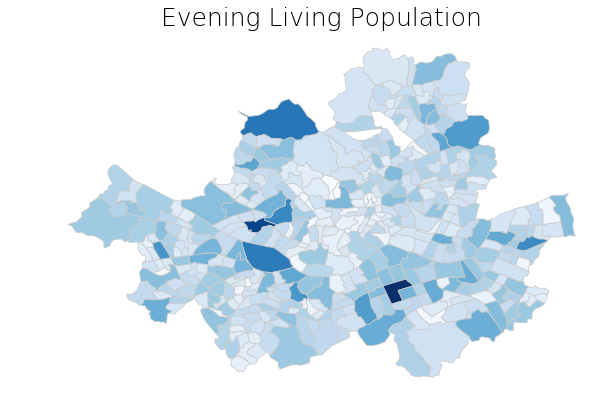

In [62]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.axis('off')
ax.set_title('Evening Living Population', fontdict={'fontsize': '25', 'fontweight' : '3'})
after_plot.plot(column='Total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

### Get the Top100 values from sorted Dataframe of  dawn, and count the unique District

In [68]:
dawn_sort = seoul_dawn[['Areacode', 'Total', 'District', 'Neighborhood']].groupby(['District', 'Neighborhood', 'Areacode']).sum().sort_values(by='Total', ascending=False)
dawn_total = dawn_sort['Total'].sum()
dawn_sort['Per'] = (dawn_sort['Total'] / dawn_total) * 100
dawn_sort = dawn_sort.reset_index()

dawn_sort_100 = dawn_sort.head(100)

In [75]:
dawn_sort_100.head()

,District,Neighborhood,Areacode,Total,Per
0,강남구,역삼1동,11680640,13317512,0.676090
1,은평구,진관동,11380690,12262365,0.622523
2,강동구,길동,11740685,10838712,0.550249
3,동작구,상도1동,11590530,10614079,0.538845
4,강서구,화곡1동,11500540,10526261,0.534387


In [30]:
dawn_sort_100['Per'].sum()

37.868708872632396

In [31]:
dawn_sort_100['District'].value_counts().head(10)

송파구     12
강남구      9
강서구      9
강동구      6
은평구      5
서초구      5
구로구      5
동작구      5
노원구      5
동대문구     4
Name: District, dtype: int64

In [63]:
dawn_plot = seoul_df.merge(dawn_sort[['Areacode', 'Total']], on='Areacode')

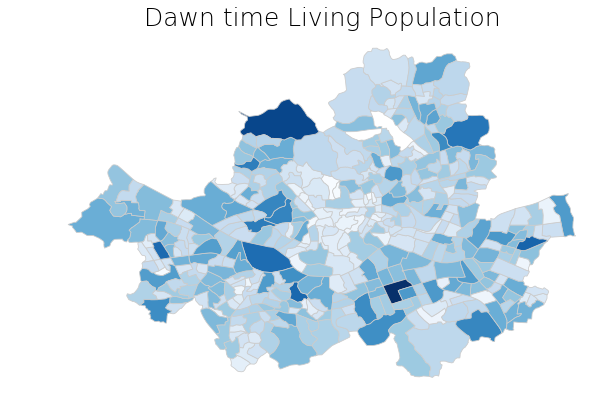

In [65]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.axis('off')
ax.set_title('Dawn time Living Population', fontdict={'fontsize': '25', 'fontweight' : '3'})
dawn_plot.plot(column='Total', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

## Data 3: Foursquare API

### Understand about dataset 

In [76]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(seoul_df['District'].unique()),
        seoul_df.shape[0]
    )
)

The dataframe has 25 boroughs and 425 neighborhoods.


In [77]:
print('The geograpical coordinate of Seoul are {}, {}.'.format(seoul_lat, seoul_long))

The geograpical coordinate of Seoul are 37.541, 126.986.


### Set variable of Foursquare Credential

In [95]:
# @hidden_cell
CLIENT_ID = 'AQYAOEFJFWC12AHJDJ1U05SKTTMUOTNG2BYYTFGKIDSDUTUN'# Foursquare ID
# Z3YXZ4HYRYM2K4YNBYBCRAD01CAOLNLOSYB2JK3SNGLGYJ3N # google
# AQYAOEFJFWC12AHJDJ1U05SKTTMUOTNG2BYYTFGKIDSDUTUN # icloud
CLIENT_SECRET = 'UUQSDTYH1J2TFESOEB4LWNJBSLTG1PNRIOCZ0W5FJRALMBF1' # Foursquare Secret
# JYSUOFMK0K3IY5XH4BD5KTXK344D1PVDOILL0MUWZCKZABK5 # google
# UUQSDTYH1J2TFESOEB4LWNJBSLTG1PNRIOCZ0W5FJRALMBF1 # icloud
VERSION = '20180605' # Foursquare API version

print('Credentails')

Credentails


### Generate python function
* empty list to store data
* API request with credential above
* GET request
* from the result, extract required data and store into emyty list
* modify list into Data Frame, and set the column name

In [96]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url =Hee Jun Yoo 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### apply above function into Top Neighborhood data by purpose

In [126]:
business_df = work_sort_100
business_df = business_df.merge(seoul_df[['Areacode', 'long', 'lat']], on='Areacode')
business_df.head()

,District,Neighborhood,Areacode,Total,Per,long,lat
0,강남구,역삼1동,11680640,53324868,1.297123,127.035491,37.500889
1,영등포구,여의동,11560540,49989377,1.215987,126.927571,37.527489
2,종로구,종로1·2·3·4가동,11110615,41123842,1.000334,126.989733,37.575077
3,마포구,서교동,11440660,36206535,0.880721,126.920945,37.554772
4,금천구,가산동,11545510,31985589,0.778047,126.884341,37.476835


In [127]:
evening_df = after_sort_100
evening_df = evening_df.merge(seoul_df[['Areacode', 'long', 'lat']], on='Areacode')
evening_df.head()

,District,Neighborhood,Areacode,Total,Per,long,lat
0,강남구,역삼1동,11680640,16311045,0.819234,127.035491,37.500889
1,마포구,서교동,11440660,15038708,0.755330,126.920945,37.554772
2,은평구,진관동,11380690,12087829,0.607120,126.940518,37.639279
3,영등포구,여의동,11560540,11818434,0.593589,126.927571,37.527489
4,서대문구,신촌동,11410585,11114291,0.558223,126.941063,37.563636


In [128]:
dawnhour_df = dawn_sort_100
dawnhour_df = dawnhour_df.merge(seoul_df[['Areacode', 'long', 'lat']], on='Areacode')
dawnhour_df.head()

,District,Neighborhood,Areacode,Total,Per,long,lat
0,강남구,역삼1동,11680640,13317512,0.676090,127.035491,37.500889
1,은평구,진관동,11380690,12262365,0.622523,126.940518,37.639279
2,강동구,길동,11740685,10838712,0.550249,127.145907,37.539725
3,동작구,상도1동,11590530,10614079,0.538845,126.953470,37.498329
4,강서구,화곡1동,11500540,10526261,0.534387,126.840936,37.533780


In [129]:
venues1 = getNearbyVenues(names=business_df['Neighborhood'],
                                   latitudes=business_df['lat'],
                                   longitudes=business_df['long']
                        )
venues2 = getNearbyVenues(names=evening_df['Neighborhood'],
                                   latitudes=evening_df['lat'],
                                   longitudes=evening_df['long']
                        )
venues3 = getNearbyVenues(names=dawnhour_df['Neighborhood'],
                                   latitudes=dawnhour_df['lat'],
                                   longitudes=dawnhour_df['long']
                        )

역삼1동
여의동
종로1·2·3·4가동
서교동
가산동
신촌동
서초3동
명동
대치2동
삼성1동
한강로동
진관동
잠실3동
영등포동
상암동
서초2동
잠실6동
구로3동
압구정동
반포4동
양재1동
논현2동
소공동
역삼2동
공릉2동
목1동
충현동
서초4동
문정2동
청담동
논현1동
노량진1동
길동
회현동
신사동
용신동
양재2동
대학동
삼성2동
상도1동
천호2동
문래동
화양동
상계6·7동
당산2동
화곡1동
사직동
혜화동
공릉1동
공항동
풍납2동
연희동
구로2동
흑석동
서초1동
잠원동
제기동
오류2동
성산2동
목5동
역촌동
구로5동
광장동
북아현동
대치4동
세곡동
전농1동
잠실2동
성수2가3동
강일동
한남동
공덕동
대방동
장안1동
반포1동
사당2동
방화2동
가양1동
가락본동
중계2·3동
등촌3동
안암동
잠실본동
종암동
방이2동
구의3동
행당1동
상계1동
오금동
발산1동
신도림동
우장산동
불광1동
청룡동
신정3동
독산1동
광희동
대흥동
사근동
방화1동
역삼1동
서교동
진관동
여의동
신촌동
길동
화곡1동
상도1동
공릉2동
서초3동
역촌동
공릉1동
노량진1동
천호2동
잠실3동
양재1동
대치2동
세곡동
오류2동
화양동
목1동
연희동
영등포동
역삼2동
당산2동
목5동
상계6·7동
종로1·2·3·4가동
잠실본동
대방동
종암동
서초4동
압구정동
광장동
강일동
성산2동
문정2동
상계1동
사당2동
중계2·3동
신정3동
상암동
불광1동
논현1동
용신동
우장산동
북가좌2동
잠원동
청룡동
가산동
장안1동
오금동
청담동
혜화동
공덕동
흑석동
방이2동
문래동
가락본동
논현2동
잠실2동
방화1동
잠실6동
대조동
신정4동
위례동
송중동
길음1동
삼성2동
대학동
반포4동
한강로동
구로2동
전농1동
공항동
구로5동
면목본동
염창동
구의3동
구로3동
녹번동
신도림동
신내1동
천호3동
장지동
반포1동
창4동
제기동
풍납2동
충현동
화곡8동
신림동
가양1동
신사동
서초2동
삼전동
발산1동
갈현2동
북아현동
묵1동
역삼1동
진관동
길동
상도1동
화곡1동
여의동
공릉2동
서교동
역촌동
신촌동
연희동
세곡동
공릉1동
서

In [130]:
print('There are {} uniques categories - Business Area.'.format(len(venues1['Venue Category'].unique())))
print('There are {} uniques categories - Evening Hot place.'.format(len(venues2['Venue Category'].unique())))
print('There are {} uniques categories - 24 Hour, Dawn Time.'.format(len(venues3['Venue Category'].unique())))

There are 237 uniques categories - Business Area.
There are 209 uniques categories - Evening Hot place.
There are 192 uniques categories - 24 Hour, Dawn Time.


### One hot encoing of all venue categories, and insert Neighborhood name at the first column

In [131]:
# one hot encoding
business_onehot = pd.get_dummies(venues1[['Venue Category']], prefix="", prefix_sep="")
evening_onehot = pd.get_dummies(venues2[['Venue Category']], prefix="", prefix_sep="")
dawntime_onehot = pd.get_dummies(venues3[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
business_onehot['Neighborhood'] = venues1['Neighborhood']
evening_onehot['Neighborhood'] = venues2['Neighborhood']
dawntime_onehot['Neighborhood'] = venues3['Neighborhood']

# move neighborhood column to the first column
fixed_columns1 = [business_onehot.columns[-1]] + list(business_onehot.columns[:-1])
business_onehot = business_onehot[fixed_columns1]

fixed_columns2 = [evening_onehot.columns[-1]] + list(evening_onehot.columns[:-1])
evening_onehot = evening_onehot[fixed_columns2]

fixed_columns3 = [dawntime_onehot.columns[-1]] + list(dawntime_onehot.columns[:-1])
dawntime_onehot = dawntime_onehot[fixed_columns3]

print(business_onehot.shape)
print(evening_onehot.shape)
print(dawntime_onehot.shape)

(2889, 238)
(2174, 210)
(1864, 193)


### To get the frequency of Neighborhood, proceed groupby and calculate mean data

In [132]:
business_grouped = business_onehot.groupby('Neighborhood').mean().reset_index()
evening_grouped = evening_onehot.groupby('Neighborhood').mean().reset_index()
dawntime_grouped = dawntime_onehot.groupby('Neighborhood').mean().reset_index()
print(business_grouped.shape)
print(evening_grouped.shape)
print(dawntime_grouped.shape)

(100, 238)
(100, 210)
(100, 193)


### Create python function to sort the venues in descending order

In [133]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### create the new dataframe and display the top 10 venues for each neighborhood
* Give number of top venues which want to get
* set indicator for 1st, 2nd, 3rd, and so on
* set column names with indicator and add string into the columns list
* create new dataframe from grouped dataframe and new columns
* slice dataframe into number of top venues

In [134]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted1 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted1['Neighborhood'] = business_grouped['Neighborhood']

for ind in np.arange(business_grouped.shape[0]):
    neighborhoods_venues_sorted1.iloc[ind, 1:] = return_most_common_venues(business_grouped.iloc[ind, :], num_top_venues)
    
# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = evening_grouped['Neighborhood']

for ind in np.arange(evening_grouped.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(evening_grouped.iloc[ind, :], num_top_venues)
    
# create a new dataframe
neighborhoods_venues_sorted3 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted3['Neighborhood'] = dawntime_grouped['Neighborhood']

for ind in np.arange(dawntime_grouped.shape[0]):
    neighborhoods_venues_sorted3.iloc[ind, 1:] = return_most_common_venues(dawntime_grouped.iloc[ind, :], num_top_venues)

In [135]:
neighborhoods_venues_sorted1.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,가락본동,Korean Restaurant,BBQ Joint,Coffee Shop,Ice Cream Shop,Fried Chicken Joint,Noodle House,Donut Shop,Dessert Shop,Pizza Place,Chinese Restaurant
1,가산동,Coffee Shop,Korean Restaurant,Outlet Store,Fast Food Restaurant,Sporting Goods Shop,Chinese Restaurant,Steakhouse,Bakery,BBQ Joint,Japanese Restaurant
2,가양1동,Gym,Gym / Fitness Center,Botanical Garden,Café,Art Gallery,Fast Food Restaurant,Exhibit,Farm,Farmers Market,Flea Market
3,강일동,Ice Cream Shop,Coffee Shop,Fast Food Restaurant,Bus Station,Bakery,Donut Shop,Gym,Discount Store,Dim Sum Restaurant,Food Court
4,공덕동,Coffee Shop,Korean Restaurant,Seafood Restaurant,Bakery,Fast Food Restaurant,Noodle House,Japanese Restaurant,Fried Chicken Joint,Sushi Restaurant,Beer Bar
5,공릉1동,Coffee Shop,Korean Restaurant,Noodle House,Electronics Store,Chinese Restaurant,Trail,Japanese Restaurant,Donut Shop,Asian Restaurant,Café
6,공릉2동,Gun Range,Park,Mountain,Historic Site,Bus Station,Café,Food,Flower Shop,Flea Market,Fish Market
7,공항동,Airport Lounge,Airport Terminal,BBQ Joint,Korean Restaurant,Airport Service,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
8,광장동,Coffee Shop,Korean Restaurant,Trail,Fried Chicken Joint,Bakery,Modern European Restaurant,Pizza Place,Bus Stop,Seafood Restaurant,Sushi Restaurant
9,광희동,Hotel,Korean Restaurant,Coffee Shop,Shopping Mall,Dessert Shop,Noodle House,Indian Restaurant,Bakery,BBQ Joint,Café


In [136]:
neighborhoods_venues_sorted2.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,가락본동,Korean Restaurant,BBQ Joint,Coffee Shop,Pizza Place,Donut Shop,Fried Chicken Joint,Noodle House,Chinese Restaurant,Bakery,Bubble Tea Shop
1,가산동,Coffee Shop,Korean Restaurant,Outlet Store,Fast Food Restaurant,Sporting Goods Shop,Japanese Restaurant,BBQ Joint,Buffet,Multiplex,Steakhouse
2,가양1동,Gym / Fitness Center,Gym,Botanical Garden,Art Gallery,Café,Food Truck,Food Court,Food & Drink Shop,Food,Flea Market
3,갈현2동,Bakery,Sushi Restaurant,Fast Food Restaurant,Bus Line,Park,Event Space,Food Truck,Food Court,Food & Drink Shop,Food
4,강일동,Bakery,Gym,Ice Cream Shop,Coffee Shop,Donut Shop,Bus Station,Fast Food Restaurant,Food Truck,Food Court,Food & Drink Shop
5,공덕동,Coffee Shop,Korean Restaurant,Seafood Restaurant,Bakery,Noodle House,Fast Food Restaurant,Japanese Restaurant,Fried Chicken Joint,Beer Bar,Sushi Restaurant
6,공릉1동,Korean Restaurant,Coffee Shop,Noodle House,Pizza Place,Trail,Fast Food Restaurant,Steakhouse,Café,Electronics Store,Japanese Restaurant
7,공릉2동,Gun Range,Mountain,Café,Historic Site,Bus Station,Park,Food Court,Food & Drink Shop,Food,Flea Market
8,공항동,Airport Lounge,Airport Service,Airport Terminal,BBQ Joint,Korean Restaurant,Exhibit,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
9,광장동,Coffee Shop,Korean Restaurant,Fried Chicken Joint,Trail,Bakery,Sushi Restaurant,Snack Place,Pizza Place,Concert Hall,Modern European Restaurant


In [137]:
neighborhoods_venues_sorted3.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,가락본동,Korean Restaurant,BBQ Joint,Coffee Shop,Bubble Tea Shop,Noodle House,Chinese Restaurant,Bakery,Donut Shop,Fried Chicken Joint,Dessert Shop
1,가산동,Coffee Shop,Korean Restaurant,Outlet Store,Fast Food Restaurant,Sporting Goods Shop,Donut Shop,Taco Place,Japanese Restaurant,Bakery,BBQ Joint
2,가양1동,Gym / Fitness Center,Art Gallery,Gym,Café,Botanical Garden,Dessert Shop,Event Space,Food Truck,Food Court,Food
3,강일동,Gym,Ice Cream Shop,Coffee Shop,Fast Food Restaurant,Donut Shop,Bus Station,Bakery,Electronics Store,Food Court,Food
4,개봉2동,Electronics Store,Ice Cream Shop,Department Store,Snack Place,Metro Station,Donut Shop,Bakery,Event Space,Food Court,Food
5,공덕동,Coffee Shop,Korean Restaurant,Bakery,Seafood Restaurant,Japanese Restaurant,Fast Food Restaurant,Noodle House,Sushi Restaurant,Beer Bar,Chinese Restaurant
6,공릉1동,Korean Restaurant,Coffee Shop,Noodle House,Electronics Store,Café,Donut Shop,Chinese Restaurant,Trail,Japanese Restaurant,Steakhouse
7,공릉2동,Gun Range,Mountain,Historic Site,Bus Station,Park,Café,Dessert Shop,Deli / Bodega,Food,Flea Market
8,공항동,Airport Lounge,Airport Terminal,Korean Restaurant,BBQ Joint,Airport Service,Department Store,Food Truck,Food Court,Food,Flea Market
9,광장동,Coffee Shop,Korean Restaurant,Bakery,Fried Chicken Joint,Trail,Modern European Restaurant,Concert Hall,Road,Sake Bar,Café


### Set the number of clusters, drop the unnecessary column, and fitting the data into K-means

In [206]:
# set number of clusters
kclusters = 4

business_grouped_clustering = business_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=26).fit(business_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 1, 1, 0, 0, 1, 2, 0, 0], dtype=int32)

In [207]:
# set number of clusters
kclusters = 4

evening_grouped_clustering = evening_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=26).fit(evening_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10] 

array([3, 1, 2, 2, 1, 1, 1, 2, 3, 1], dtype=int32)

In [208]:
# set number of clusters
kclusters = 4

dawntime_grouped_clustering = dawntime_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans3 = KMeans(n_clusters=kclusters, random_state=26).fit(dawntime_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans3.labels_[0:10] 

array([3, 3, 0, 2, 0, 3, 3, 0, 3, 3], dtype=int32)

### insert the above label result into top number venue dataframe, and get the geolocation data from dfs

In [209]:
# incase reset cluster number above
# neighborhoods_venues_sorted1.drop('Cluster Labels', axis=1, inplace=True)
# neighborhoods_venues_sorted2.drop('Cluster Labels', axis=1, inplace=True)
# neighborhoods_venues_sorted3.drop('Cluster Labels', axis=1, inplace=True)

# add clustering labels
neighborhoods_venues_sorted1.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans2.labels_)
neighborhoods_venues_sorted3.insert(0, 'Cluster Labels', kmeans3.labels_)

dfs_merged1 = business_df
dfs_merged2 = evening_df
dfs_merged3 = dawnhour_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfs_merged1 = dfs_merged1.join(neighborhoods_venues_sorted1.set_index('Neighborhood'), on='Neighborhood')
dfs_merged2 = dfs_merged2.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')
dfs_merged3 = dfs_merged3.join(neighborhoods_venues_sorted3.set_index('Neighborhood'), on='Neighborhood')

### Remove NA value from the data frame, and reset the columns data type into integer

In [210]:
dfs_merged1 = dfs_merged1[dfs_merged1['Cluster Labels'].notna()]
dfs_merged1['Cluster Labels'] = dfs_merged1['Cluster Labels'].astype(int)

dfs_merged2 = dfs_merged2[dfs_merged2['Cluster Labels'].notna()]
dfs_merged2['Cluster Labels'] = dfs_merged2['Cluster Labels'].astype(int)

dfs_merged3 = dfs_merged3[dfs_merged3['Cluster Labels'].notna()]
dfs_merged3['Cluster Labels'] = dfs_merged3['Cluster Labels'].astype(int)

### Select Top 10 Neighborhood from Each Data Set

In [228]:
work_10 = work_sort_100.head(5)
after_10 = after_sort_100.head(5)
dawn_10 = dawn_sort_100.head(5)

### Business Area - Clustering 1 - Coffee

In [229]:
dfs_merged1_loc = dfs_merged1.loc[dfs_merged1['Cluster Labels'] == 0, dfs_merged1.columns[[1] + list(range(5, dfs_merged1.shape[1]))]]
# dfs_merged1_loc
dfs_merged1_loc[dfs_merged1_loc['Neighborhood'].isin(work_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,여의동,126.927571,37.527489,0,Coffee Shop,Park,Café,Plaza,BBQ Joint,Korean Restaurant,Night Market,Japanese Restaurant,Hotel,Metro Station
3,서교동,126.920945,37.554772,0,Korean Restaurant,Coffee Shop,Café,BBQ Joint,Dessert Shop,Chinese Restaurant,Japanese Restaurant,Bar,Bakery,Hotel
4,가산동,126.884341,37.476835,0,Coffee Shop,Korean Restaurant,Outlet Store,Fast Food Restaurant,Sporting Goods Shop,Chinese Restaurant,Steakhouse,Bakery,BBQ Joint,Japanese Restaurant


### Business Area - Clustering 2 - Stores or Activity

In [230]:
dfs_merged1_loc = dfs_merged1.loc[dfs_merged1['Cluster Labels'] == 1, dfs_merged1.columns[[1] + list(range(5, dfs_merged1.shape[1]))]]
# dfs_merged1_loc
dfs_merged1_loc[dfs_merged1_loc['Neighborhood'].isin(work_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Business Area - Clustering 3 - Restaurant

In [231]:
dfs_merged1_loc = dfs_merged1.loc[dfs_merged1['Cluster Labels'] == 2, dfs_merged1.columns[[1] + list(range(5, dfs_merged1.shape[1]))]]
# dfs_merged1_loc
dfs_merged1_loc[dfs_merged1_loc['Neighborhood'].isin(work_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,역삼1동,127.035491,37.500889,2,Korean Restaurant,BBQ Joint,Coffee Shop,Chinese Restaurant,Hotel,Japanese Restaurant,Salad Place,Sushi Restaurant,Italian Restaurant,Sake Bar
2,종로1·2·3·4가동,126.989733,37.575077,2,Korean Restaurant,Tea Room,Café,Coffee Shop,Dumpling Restaurant,Beer Bar,Restaurant,Italian Restaurant,Museum,Hostel


### Business Area - Clustering 4 - Natural Environment

In [232]:
dfs_merged1_loc = dfs_merged1.loc[dfs_merged1['Cluster Labels'] == 3, dfs_merged1.columns[[1] + list(range(5, dfs_merged1.shape[1]))]]
# dfs_merged1_loc
dfs_merged1_loc[dfs_merged1_loc['Neighborhood'].isin(work_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [242]:
dfs_merged2[dfs_merged2['Neighborhood'].isin(after_10['Neighborhood'])]

,District,Neighborhood,Areacode,Total,Per,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,강남구,역삼1동,11680640,16311045,0.819234,127.035491,37.500889,3,Korean Restaurant,BBQ Joint,Coffee Shop,Chinese Restaurant,Hotel,Japanese Restaurant,Café,Sake Bar,Salad Place,Sushi Restaurant
1,마포구,서교동,11440660,15038708,0.755330,126.920945,37.554772,2,Korean Restaurant,Coffee Shop,Café,BBQ Joint,Dessert Shop,Chinese Restaurant,Bakery,Hotel,Bar,Japanese Restaurant
2,은평구,진관동,11380690,12087829,0.607120,126.940518,37.639279,1,Coffee Shop,Bakery,Planetarium,Café,Museum,Bistro,Trail,Food Truck,Food Court,Food & Drink Shop
3,영등포구,여의동,11560540,11818434,0.593589,126.927571,37.527489,2,Coffee Shop,Park,Café,Korean Restaurant,Japanese Restaurant,Hotel,BBQ Joint,Night Market,Plaza,Fried Chicken Joint
4,서대문구,신촌동,11410585,11114291,0.558223,126.941063,37.563636,1,Coffee Shop,Korean Restaurant,Bakery,Bubble Tea Shop,Donut Shop,Dessert Shop,Sandwich Place,Japanese Restaurant,French Restaurant,Multiplex


### Hot Place - Clustering 1 - Stores

In [238]:
dfs_merged2_loc = dfs_merged2.loc[dfs_merged2['Cluster Labels'] == 0, dfs_merged2.columns[[1] + list(range(5, dfs_merged2.shape[1]))]]
# dfs_merged2_loc
dfs_merged2_loc[dfs_merged2_loc['Neighborhood'].isin(after_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Hot Place - Clustering 2 - Coffee Shop

In [239]:
dfs_merged2_loc = dfs_merged2.loc[dfs_merged2['Cluster Labels'] == 1, dfs_merged2.columns[[1] + list(range(5, dfs_merged2.shape[1]))]]
# dfs_merged2_loc
dfs_merged2_loc[dfs_merged2_loc['Neighborhood'].isin(after_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,진관동,126.940518,37.639279,1,Coffee Shop,Bakery,Planetarium,Café,Museum,Bistro,Trail,Food Truck,Food Court,Food & Drink Shop
4,신촌동,126.941063,37.563636,1,Coffee Shop,Korean Restaurant,Bakery,Bubble Tea Shop,Donut Shop,Dessert Shop,Sandwich Place,Japanese Restaurant,French Restaurant,Multiplex


### Hot Place - Clustering 3 - Activity, Natural environment

In [240]:
dfs_merged2_loc = dfs_merged2.loc[dfs_merged2['Cluster Labels'] == 2, dfs_merged2.columns[[1] + list(range(5, dfs_merged2.shape[1]))]]
# dfs_merged2_loc
dfs_merged2_loc[dfs_merged2_loc['Neighborhood'].isin(after_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,서교동,126.920945,37.554772,2,Korean Restaurant,Coffee Shop,Café,BBQ Joint,Dessert Shop,Chinese Restaurant,Bakery,Hotel,Bar,Japanese Restaurant
3,여의동,126.927571,37.527489,2,Coffee Shop,Park,Café,Korean Restaurant,Japanese Restaurant,Hotel,BBQ Joint,Night Market,Plaza,Fried Chicken Joint


### Hot Place - Clustering 4 - Restaurant

In [241]:
dfs_merged2_loc = dfs_merged2.loc[dfs_merged2['Cluster Labels'] == 3, dfs_merged2.columns[[1] + list(range(5, dfs_merged2.shape[1]))]]
# dfs_merged2_loc
dfs_merged2_loc[dfs_merged2_loc['Neighborhood'].isin(after_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,역삼1동,127.035491,37.500889,3,Korean Restaurant,BBQ Joint,Coffee Shop,Chinese Restaurant,Hotel,Japanese Restaurant,Café,Sake Bar,Salad Place,Sushi Restaurant


### Dawn Time - Clustering 1 - Coffee Shop

In [257]:
dfs_merged3_loc = dfs_merged3.loc[dfs_merged3['Cluster Labels'] == 0, dfs_merged3.columns[[1] + list(range(5, dfs_merged3.shape[1]))]]
# dfs_merged3_loc
dfs_merged3_loc[dfs_merged3_loc['Neighborhood'].isin(dawn_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,화곡1동,126.840936,37.53378,0,Bakery,Ice Cream Shop,Pizza Place,Bus Station,Grocery Store,Market,Yoga Studio,Food,Flea Market,Fish Market


### Dawn Time - Clustering 2 - Activity

In [253]:
dfs_merged3_loc = dfs_merged3.loc[dfs_merged3['Cluster Labels'] == 1, dfs_merged3.columns[[1] + list(range(5, dfs_merged3.shape[1]))]]
# dfs_merged3_loc
dfs_merged3_loc[dfs_merged3_loc['Neighborhood'].isin(dawn_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


### Dawn Time - Clustering 3 - Bakery / Shop

In [254]:
dfs_merged3_loc = dfs_merged3.loc[dfs_merged3['Cluster Labels'] == 2, dfs_merged3.columns[[1] + list(range(5, dfs_merged3.shape[1]))]]
# dfs_merged3_loc
dfs_merged3_loc[dfs_merged3_loc['Neighborhood'].isin(dawn_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,진관동,126.940518,37.639279,2,Bakery,Coffee Shop,Café,Museum,Planetarium,Bistro,Trail,Food,Flea Market,Fish Market


### Dawn Time - Clustering 4 - Restaurant

In [255]:
dfs_merged3_loc = dfs_merged3.loc[dfs_merged3['Cluster Labels'] == 3, dfs_merged3.columns[[1] + list(range(5, dfs_merged3.shape[1]))]]
# dfs_merged3_loc
dfs_merged3_loc[dfs_merged3_loc['Neighborhood'].isin(dawn_10['Neighborhood'])]

,Neighborhood,long,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,역삼1동,127.035491,37.500889,3,Korean Restaurant,BBQ Joint,Coffee Shop,Chinese Restaurant,Hotel,Japanese Restaurant,Café,Italian Restaurant,Sushi Restaurant,Sake Bar
2,길동,127.145907,37.539725,3,Korean Restaurant,Flea Market,Noodle House,Bus Stop,Bakery,Yoga Studio,Food Court,Food,Fish Market,Fast Food Restaurant
3,상도1동,126.953470,37.498329,3,Coffee Shop,Korean Restaurant,Sandwich Place,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Dumpling Restaurant,Donut Shop,Flea Market
